# Numerical Integration and Differentiation

This notebook illustrates how to perform numerical integration and differentiation. 

There are several packages for doing this. Here, the focus is on QuadGK (https://github.com/JuliaMath/QuadGK.jl) and ForwardDiff (https://github.com/JuliaDiff/ForwardDiff.jl).

## Load Packages

In [1]:
using QuadGK, ForwardDiff

using Compat, Missings        #in Julia 0.6 
#using Dates                  #in Julia 0.7

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots

backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

# Numerical Integration

As a simple illustration, the next cells plot and integrate the $N(0,1)$ pdf.

## The Pdf of the N(μ,σ²) Distribution 

(Notice: the function takes $\mu$ and $\sigma^2$ as inputs. This differs from the Distributions package.) 

In [3]:
function ϕNS(x,μ=0,σ²=1)       #pdf of N(μ,σ²), defaults to N(0,1)
    σ = sqrt(σ²)
    z = (x - μ)/σ
    pdf = exp(-0.5*z^2)/(sqrt(2*pi)*σ)    
    return pdf
end

ϕNS (generic function with 3 methods)

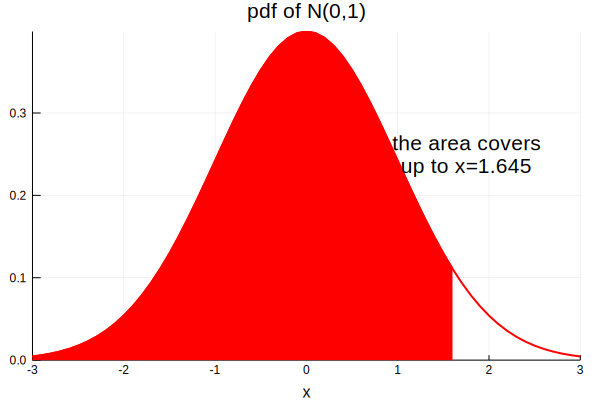

In [4]:
x  = -3:0.1:3
xb = x[x.<=1.645]

plot1 = plot(x,ϕNS.(x),color=:red,linewidth=2,legend=nothing)
plot!(xb,ϕNS.(xb),color=:red,linewidth=2,legend=nothing,fill=(0,:red))
title!("pdf of N(0,1)")
xlabel!("x")
ylabel!("")
annotate!(1.75,0.25,"the area covers\n up to x=1.645")

## Calculating Prob(x<=1.645)

The next cell calculates (by numeric integration)

$\int_{-\infty}^{1.645}\phi(x,0,\sigma^2)dx$,

where $\phi(x,\mu,\sigma^2)$ is the pdf of an $N(\mu,\sigma^2)$ variable.

In [5]:
cdf1, = QuadGK.quadgk(x->ϕNS(x),-Inf,1.645)       #could replace x->ϕNS(x), by ϕNS
printlnPs("\nPr(x<=1.64) according to N(0,1):", cdf1)

cdf2, = QuadGK.quadgk(x->ϕNS(x,0,5),-Inf,1.645)
printlnPs("\nPr(x<=1.64) according to N(0,5):", cdf2)


Pr(x<=1.64) according to N(0,1):     0.950

Pr(x<=1.64) according to N(0,5):     0.769


# Numerical Derivatives

Numerical derivatives can be calculated by a crude finite difference (see `NumDer()` below) or by the much more sophisticated routines in the ForwardDiff.jl package.

The function you want to differentiate must typically have only one argument (even if it is a vector). To turn a multi-argument function fn1(x,a) into a one-argument function transform it to an anonymous function by
```
x->fn1(x,a),
```
assuming that `a` has a value already. We can now differentiate wrt. `x`.

In [6]:
function NumDer(fun,b0,h)     #crude function for a centered numerical derivative
    bminus = b0 .- h
    bplus  = b0 .+ h
    hh     = bplus - bminus
    fplus  = fun(bplus)
    fminus = fun(bminus)
    D      = (fplus-fminus)/hh
    return D
end

NumDer (generic function with 1 method)

In [7]:
function fn1(x,a)                 #a simple function, to be differentiated
   return (x - 1.1)^2 - a                
end

fn1 (generic function with 1 method)

In [8]:
x0 = 2

dydx_A = NumDer(x->fn1(x,0.5),x0,0.01)           #differentiate fn1(x,0.5) at x = x0
dydx_B = ForwardDiff.derivative(x->fn1(x,0.5),x0)

println("The derivative at x=$x0 is (from two different methods): ")
printmat([dydx_A dydx_B])

The derivative at x=2 is (from two different methods): 
     1.800     1.800



In [9]:
x = -3:6/99:6          #calculate the derivative at many points

dydx_A = [NumDer(x->fn1(x,0.5),x[i],0.01) for i=1:length(x)]        

dydx_B = [ForwardDiff.derivative(x->fn1(x,0.5),x[i]) for i=1:length(x)]

println("now lets plot this")

now lets plot this


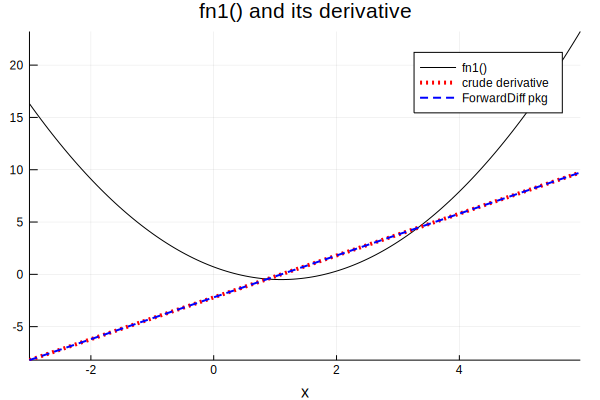

In [10]:
plot(x,fn1.(x,0.5),color=:black,label="fn1()")
plot!(x,dydx_A,color=:red,line=(:dot,4),label="crude derivative")
plot!(x,dydx_B,color=:blue,line=(:dash,2),label="ForwardDiff pkg ")
title!("fn1() and its derivative")
xlabel!("x")
ylabel!("")

## (extra) Comments on Using the ForwardDiff Package

The ForwardDiff package applies an interesting approach to calculate derivatives, using a special number type ("dual numbers"). This means that your code must be able to handle such numbers. In most cases, that is not a problem, but you may have to watch out if you create arrays to store (intermediate?) results inside the function. See the examples below

In [11]:
function fnDoesNotWork(b,a)
    z = zeros(length(b))              #will not work with ForwardDiff, since
    for i = 1:length(z)               #z cannot store dual numbers
        z[i] = b[i]*i
    end    
    return sum(z) + a
end    

function fnDoesWork(b,a)
    z = zeros(eltype(b),length(b))   #will work with ForwardDiff, since
    for i = 1:length(z)              #when b is a dual number, so is z 
        z[i] = b[i]*i
    end    
    return sum(z) + a
end

fnDoesWork (generic function with 1 method)

In [12]:
b0 = [1.5,2]

try
    ForwardDiff.gradient(b->fnDoesNotWork(b,1),b0)
    println("using fnDoesNotWork(): ",dydx)
catch    
    dydx = ForwardDiff.gradient(b->fnDoesWork(b,1),b0)
    println("using fnDoesWork(): ",dydx)    
end

using fnDoesWork(): [1.0, 2.0]
